# Market Timing

Market Timing is often considered a strategy for beating the markets and making profits. We would try to explore whether market timing actually works. We would work with the NIFTY index.

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

In [15]:
# Load your data here
filename = '/home/machine/Downloads/NIFTY 50_Data.csv'
df = pd.read_csv(filename, parse_dates=['Date'])
df.rename(lambda x: x.lower(), axis='columns', inplace=True)
df = df.set_index('date').sort_index()

## Dollar averaging method

Dollar averaging is one of the most popular methods used in investment. Under this method, we would buying a stock or an index fund at periodic intervals irrespective of trend. The underlying assumption is equity markets are profitable in the long run and investing them over periodic intervals for a long period of time would lead to the benefits of compounding.


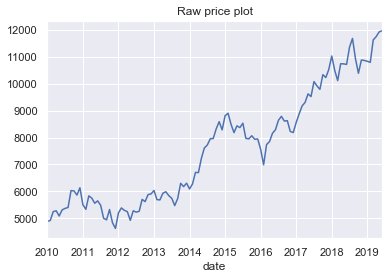

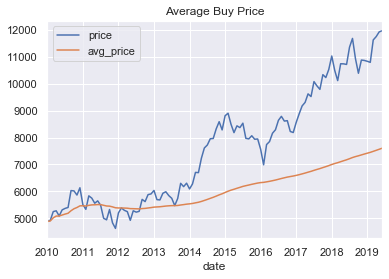

In [ ]:
# Buy index at the close price of each month; assume integer quantities
freq = 'M' # buy every month - W for week; 2W for every 2 weeks
capital = 40000 # investment every period
df2 = df.resample(freq).close.last().reset_index()
df2.columns = ['date', 'price']
df2['avg_price'] = df2.price.expanding().mean()
df2['capital'] = capital * (df2.index+1)
df2['qty'] = (capital/df2['price']).astype(int)
df2['value'] = df2.qty.cumsum() * df2.price
df2.set_index('date').price.plot(title='Raw price plot of the index')
df2.set_index('date')[['price', 'avg_price']].plot(title='Average Buy Price')
df2.set_index('date')[['capital', 'value']].plot(
    title='Invested Capital vs Value of Investment')

So ,it took 4 years before your investment start getting returns on your capital.

You would be in for a surprise if you change the frequency to weekly **W**.

Hint `(capital/df2['price']).astype(int)`

And the below figure explains 